# Instalação

Libs necessárias: pip install -r requirements.txt

In [105]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings

# 0. Lendo o arquivo

In [106]:
df = pd.read_csv( 'dataset/top10K-TMDB-movies.csv' )
df.shape

(10000, 9)

# 1. Pré-processamento da base de dados

## 1.1 Valores Ausentes

### 1.1.1 Ver se há algum valor ausente no DataFrame

Retorna `True` se houver pelo menos um valor ausente.

In [107]:
df.isnull().values.any()

np.True_

### 1.1.2 Contar quantos valores ausentes há em cada coluna

In [108]:
df.isnull().sum()

id                    0
title                 0
genre                 3
original_language     0
overview             13
popularity            0
release_date          0
vote_average          0
vote_count            0
dtype: int64

### 1.1.3 Exibir linhas que possuem valores ausentes

In [109]:
df[ df.isnull().any( axis = 1 ) ]

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count
3361,50472,Anplagghed al cinema,NaN,it,"A queue at the ATM machine, a displaced family...",4.420,2006-11-26,7.0,313
4150,38537,Nati stanchi,Comedy,it,NaN,5.671,2002-03-01,6.8,211
6973,31359,Would I Lie to You? 2,Comedy,fr,NaN,4.741,2001-02-07,6.2,325
7821,43211,7 Kilos in 7 Days,NaN,it,Two not very clever young doctors open a fitne...,5.885,1986-02-02,6.0,212
7941,2029,Tanguy,Comedy,fr,NaN,5.449,2001-11-21,6.0,387
8518,57114,"Amore, bugie e calcetto",NaN,en,NaN,4.709,2008-04-04,5.8,200
9293,17413,Incognito,Comedy,fr,NaN,5.602,2009-04-28,5.5,213
9440,516043,Arrivano i prof,Comedy,it,NaN,6.558,2018-05-01,5.4,337
9620,154512,Lightning Strike,Comedy,it,NaN,4.070,2012-12-13,5.3,216
9792,42426,A spasso nel tempo - L'avventura continua,"Comedy,Fantasy",it,NaN,5.020,1997-12-11,5.1,209


### 1.1.4 Removendo linhas com valores ausentes

In [110]:
df.dropna( subset = [ 'overview' ], inplace = True )
df.reset_index( drop = True, inplace = True )

## 1.2 Valores Duplicados

### 1.2.1 Ver se há alguma linha duplicada

Retorna `True` se houver ao menos uma linha duplicada

In [111]:
df.duplicated().any()

np.False_

### 1.2.2 Contar o número de linhas duplicadas

In [112]:
df.duplicated().sum()

np.int64(0)

### 1.2.3 Ver quais são as linhas duplicadas

In [113]:
df[ df.duplicated() ]

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count


# 2. Seleção de Atributos

In [114]:
df = df[ [ 'id', 'title', 'overview', "genre" ] ]
df.shape

(9987, 4)

In [115]:
df[ 'tags' ] = df[ 'overview' ] + df[ 'genre' ]
df.shape

(9987, 5)

In [116]:
df_new = df.drop( columns = [ 'overview', 'genre' ] )
df_new.shape

(9987, 3)

# 2. Similaridade de Cossenos

Imagine que cada sinopse de filme, depois de ser transformada em números (seja por Bag of Words ou TF-IDF), se torna um vetor em um espaço com muitas dimensões (onde cada dimensão corresponde a uma palavra do vocabulário).

## 2.1 **A Ideia Central**

A similaridade de cossenos **não mede a distância** entre as pontas desses vetores, mas sim o ângulo entre eles.

- Se dois vetores apontam para **direções muito parecidas**, o ângulo entre eles é pequeno, e a similaridade de cossenos é alta (próxima de 1). Isso sugere que as sinopses usam palavras/termos de forma parecida, indicando temas semelhantes.
- Se dois vetores apontam para **direções completamente diferentes** (são ortogonais, formam um ângulo de 90 graus), a similaridade de cossenos é 0. Isso sugere que as sinopses tratam de assuntos muito distintos, com poucas palavras-chave em comum.
- Se dois vetores apontam para **direções opostas**, o ângulo é de 180 graus, e a similaridade de cossenos é -1. Na prática, com vetores de texto baseados em contagens (BoW) ou TF-IDF, que geralmente não têm valores negativos, a similaridade varia entre 0 e 1.

## 2.2 **Exemplo**

Vamos simplificar muito e imaginar um vocabulário minúsculo com apenas 3 palavras: "ação", "comédia", "drama".

Agora, vamos representar 3 filmes com vetores baseados na contagem dessas palavras em suas (hipotéticas) sinopses:

- Filme A: "Muita ação e um pouco de drama."
    - Vetor A = [ação: 2, comédia: 0, drama: 1] -> [2, 0, 1]
- Filme B: "Pura ação!"
    - Vetor B = [ação: 1, comédia: 0, drama: 0] -> [1, 0, 0]
- Filme C: "Uma comédia dramática."
    - Vetor C = [ação: 0, comédia: 1, drama: 1] -> [0, 1, 1]

Agora, vamos calcular a similaridade de cossenos (sem entrar nos detalhes matemáticos exatos aqui, apenas a intuição):

- Similaridade(A, B):
    - Ambos têm "ação". O Filme A também tem "drama", o Filme B não.
    - Os vetores [2, 0, 1] e [1, 0, 0] apontam em direções relativamente parecidas (ambos têm um forte componente na dimensão "ação").
    - A similaridade de cossenos será alta, mas não 1 (porque A também tem "drama").
- Similaridade(A, C):
    - Ambos têm "drama". O Filme A tem "ação", o Filme C tem "comédia".
    - Os vetores [2, 0, 1] e [0, 1, 1] compartilham a dimensão "drama", mas divergem nas outras ("ação" vs "comédia").
    - A similaridade de cossenos será média-baixa.
- Similaridade(B, C):
    - Não compartilham nenhuma palavra do nosso vocabulário ("ação" vs "comédia", "drama").
    - Os vetores [1, 0, 0] e [0, 1, 1] apontam em direções muito diferentes.
    - A similaridade de cossenos será próxima de 0.

## 2.3 **Matematicamente**

A fórmula é:

$$
\text{similaridade(A,B)} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

Onde:
- $ \mathbf{A} \cdot \mathbf{B} $ é o produto escalar dos vetores (soma da multiplicação de cada componente correspondente).
- $ \|\mathbf{A}\|$ e $ \|\mathbf{B}\| $ são as magnitudes (ou "comprimentos") dos vetores.

# 3. Vetorização das Sinopses

Para que os algoritmos de machine learning compreendam e processem dados textuais, como as sinopses ou tags dos filmes, precisamos primeiro convertê-los em vetores numéricos. Bag of Words (BoW) e TF-IDF são duas abordagens fundamentais e amplamente utilizadas para essa tarefa de **vetorização**.

## 3.1 Bag of Worlds (BoW)

* **Ideia Central:** Representar um texto pela frequência (contagem) de suas palavras, ignorando a ordem ou a gramática.
* **Como Funciona:**
    1.  **Construção do Vocabulário:** Primeiro, cria-se um vocabulário que contém todas as palavras únicas encontradas em *todos* os textos do conjunto de dados (corpus).
    2.  **Criação do Vetor:** Para cada texto individual, cria-se um vetor numérico. O tamanho desse vetor é igual ao tamanho do vocabulário.
    3.  **Contagem:** Cada posição no vetor corresponde a uma palavra específica do vocabulário. O valor nessa posição é simplesmente quantas vezes aquela palavra aparece no texto que está sendo vetorizado.
* **Analogia:** Imagine que você joga todas as palavras de um documento dentro de uma "sacola" (bag). O BoW apenas conta quantas vezes cada palavra única está presente nessa sacola.
* **Características:**
    * Simples e fácil de entender.
    * Perde a informação sobre a ordem das palavras.
    * Trata todas as palavras da mesma forma; palavras muito frequentes (como artigos ou preposições, se não removidas por *stop words*) podem dominar o vetor, mesmo sem carregar tanto significado distintivo.
* **Implementação:** Em Scikit-learn, é feito usando o `CountVectorizer`.

In [117]:
bow_vectorizer = CountVectorizer( max_features = 10000, stop_words = 'english' )
bow_matrix = bow_vectorizer.fit_transform( df_new[ 'tags' ].values.astype( 'U' ) ).toarray()

cosine_sim_bow = cosine_similarity( bow_matrix )

## 3.2 TF-IDF (Term Frequency-Inverse Document Frequency)

* **Ideia Central:** É uma evolução do BoW que tenta dar mais importância às palavras que são significativas para um texto específico, ao mesmo tempo que diminui o peso das palavras que são muito comuns em *todos* os textos. O peso de cada palavra reflete sua importância naquele documento dentro do contexto de toda a coleção.
* **Como Funciona:** Calcula um score para cada palavra em cada documento, baseado em dois fatores:
    1.  **TF (Term Frequency - Frequência do Termo):** Mede quantas vezes uma palavra aparece no documento atual. Quanto mais vezes aparece, maior o TF (geralmente normalizado). Indica a importância da palavra *dentro* daquele documento.
    2.  **IDF (Inverse Document Frequency - Frequência Inversa do Documento):** Mede o quão rara ou comum a palavra é em *toda a coleção* de documentos. É calculado como o logaritmo da divisão do número total de documentos pelo número de documentos que contêm a palavra ($ \log(\frac{N}{df_t}) $). Palavras que aparecem em muitos documentos terão um IDF baixo (ex: "filme", "ele"), enquanto palavras que aparecem em poucos documentos terão um IDF alto (ex: "multiverso", "hobbit"). Indica a informatividade ou poder discriminatório da palavra.
    3.  **Score TF-IDF:** É o produto $ TF \times IDF $. Uma palavra terá um score TF-IDF alto se for frequente em um documento específico (alto TF) mas rara no conjunto geral de documentos (alto IDF).
* **Características:**
    * Dá mais peso a palavras que são boas indicadoras do conteúdo específico de um documento.
    * Reduz o peso de palavras muito comuns que não ajudam a distinguir entre documentos.
    * Geralmente leva a melhores resultados do que o BoW em tarefas de busca, classificação e cálculo de similaridade.
* **Implementação:** Em Scikit-learn, é feito usando o `TfidfVectorizer`.

In [118]:
tfidf_vectorizer = TfidfVectorizer( max_features = 10000, stop_words = 'english' )
tfidf_matrix = tfidf_vectorizer.fit_transform( df_new[ 'tags' ].values.astype( 'U' ) ).toarray()

cosine_sim_tfidf = cosine_similarity( tfidf_matrix )

# 4. Sistema de Recomendação

In [119]:
# Para facilitar a busca pelo filme, criamos uma Série que mapeia títulos para índices
# Isso é mais eficiente que procurar no DataFrame toda vez
indices = pd.Series( df.index, index = df[ 'title' ] ).drop_duplicates()


def recommend_by_synopsis( titulo, cosine_sim_matrix, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes baseadas na similaridade de sinopses,
    retornando títulos e suas pontuações de similaridade.

    Args:
        titulo (str): O título do filme base para a recomendação.
        cosine_sim_matrix (np.array): A matriz de similaridade de cossenos pré-calculada.
        data (pd.DataFrame): O DataFrame contendo os dados dos filmes.
        mapping (pd.Series): Mapeamento de títulos para índices.
        top_n (int): Número de recomendações.

    Returns:
        list: Uma lista de tuplas (titulo_recomendado, similaridade),
              ou uma mensagem de erro (str).
    """
    try:
        # Obter o índice do filme que corresponde ao título
        if titulo not in mapping:
            # Tenta encontrar correspondência ignorando maiúsculas/minúsculas e espaços extras
            matches = [ t for t in mapping.index if t.lower().strip() == titulo.lower().strip() ]
            if not matches:
                # Se ainda não encontrou, retorna erro
                raise KeyError
            # Pega o primeiro título correspondente (pode haver duplicatas exatas no índice se não tratadas)
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
            print( f"Nota: Buscando por '{actual_title}' (correspondência encontrada para '{titulo}')" )
        else:
            idx = mapping[ titulo ]  # Pega o índice diretamente se o título for exato

        # Obter as pontuações de similaridade de todos os filmes com este filme
        sim_scores = list( enumerate( cosine_sim_matrix[ idx ] ) )

        # Ordenar os filmes com base nas pontuações de similaridade (decrescente)
        sim_scores = sorted( sim_scores, key = lambda x: x[ 1 ], reverse = True )

        # Obter as pontuações e índices dos 'top_n' filmes mais similares (ignorando o próprio filme)
        sim_scores = sim_scores[ 1:top_n + 1 ]  # Pega do segundo até top_n+1

        # Criar a lista de tuplas (título, score)
        recomendacoes = [ ]
        for index, score in sim_scores:
            # Verifica se o índice é válido para evitar erros
            if index < len( data ):
                titulo_filme = data[ 'title' ].iloc[ index ]
                recomendacoes.append( (titulo_filme, score) )
            else:
                print( f"Aviso: Índice {index} fora dos limites do DataFrame. Ignorando." )

        return recomendacoes

    except KeyError:
        # Mensagem de erro mais informativa
        suggestion = [ t for t in mapping.index if titulo.lower() in t.lower() ][ :5 ]
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion:
            error_msg += f" Você quis dizer algum destes? {suggestion}"
        return error_msg
    except Exception as e:
        return f"Ocorreu um erro inesperado: {e}"


## 4.1 Aplicação

In [120]:
filme_exemplo = "The Dark Knight Rises"
filme_exemplo = "Bohemian Rhapsody"

print( f"\n--- Recomendações para '{filme_exemplo}' (BoW) ---" )
recomendacoes = recommend_by_synopsis( filme_exemplo, cosine_sim_matrix = cosine_sim_bow, top_n = 5 )

if isinstance( recomendacoes, list ):
    for i, (filme, score) in enumerate( recomendacoes ):
        print( f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
else:
    print( recomendacoes )

print( f"\n--- Recomendações para '{filme_exemplo}' (TF-IDF) ---" )
recomendacoes_2 = recommend_by_synopsis( filme_exemplo, cosine_sim_matrix = cosine_sim_tfidf, top_n = 5 )

if isinstance( recomendacoes_2, list ):
    for i, (filme, score) in enumerate( recomendacoes_2 ):
        print( f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
else:
    print( recomendacoes_2 )


--- Recomendações para 'Bohemian Rhapsody' (BoW) ---
1. The Doors (Similaridade: 0.270)
2. Tenacious D in The Pick of Destiny (Similaridade: 0.264)
3. Given (Similaridade: 0.242)
4. The Rocker (Similaridade: 0.240)
5. Ricki and the Flash (Similaridade: 0.231)

--- Recomendações para 'Bohemian Rhapsody' (TF-IDF) ---
1. The Rocker (Similaridade: 0.203)
2. Given (Similaridade: 0.189)
3. Sweet and Lowdown (Similaridade: 0.177)
4. Tenacious D in The Pick of Destiny (Similaridade: 0.174)
5. Scott Pilgrim vs. the World (Similaridade: 0.169)


# 5. Sentence-BERT

Sentence-BERT é uma técnica desenvolvida para superar uma limitação dos modelos BERT originais em tarefas de comparação de sentenças. Enquanto o BERT puro é poderoso, ele não gera, por padrão, *embeddings* (vetores) de sentenças que sejam semanticamente significativos e diretamente comparáveis usando similaridade de cossenos. Comparar a similaridade entre N sentenças exigiria N*(N-1)/2 passagens pelo modelo BERT, o que é computacionalmente inviável para grandes conjuntos de dados.

**O Objetivo do Sentence-BERT:**

O objetivo principal é criar vetores de tamanho fixo (embeddings) para sentenças individuais, de forma que a similaridade semântica entre as sentenças se traduza na proximidade desses vetores no espaço vetorial (geralmente medido pela similaridade de cossenos).

**Como Ele Consegue Isso:**

1.  **Base Pré-treinada:** Utiliza um modelo transformer pré-treinado (como BERT, RoBERTa, MPNet, etc.) como sua base.
2.  **Pooling:** Adiciona uma operação de *pooling* (como tirar a média dos vetores de saída de todas as palavras da sentença - MEAN Pooling) sobre a saída do modelo base. Isso transforma a sequência de vetores de palavras em um único vetor de tamanho fixo que representa a sentença inteira.
3.  **Fine-tuning Específico (A Chave):** A etapa crucial é o *fine-tuning*. O Sentence-BERT é treinado usando arquiteturas de redes **siamesas** ou **triplet**.
    * **Redes Siamesas:** O modelo processa duas sentenças simultaneamente e ajusta seus pesos para que o cálculo de similaridade (ex: cosseno) entre os embeddings resultantes se aproxime de um valor desejado (ex: 1 para pares sinônimos, 0 para pares não relacionados).
    * **Redes Triplet:** O modelo vê três sentenças (âncora, positiva, negativa) e aprende a fazer o embedding da âncora ser mais próximo do embedding da positiva do que do embedding da negativa.
    * Esse fine-tuning ensina o modelo a produzir embeddings que realmente refletem o significado semântico para fins de comparação.

**Uso (Inferência):**

Uma vez que o modelo está fine-tunado (ou quando usamos um modelo pré-treinado já fine-tunado com essa técnica, como `all-mpnet-base-v2` ou `paraphrase-multilingual-mpnet-base-v2`), podemos simplesmente passar **uma única sentença** por ele para obter seu embedding. Isso é muito rápido e eficiente. Com todos os embeddings gerados, podemos calcular similaridades (ex: cosseno) entre quaisquer pares de vetores de forma quase instantânea.

**Resultado:**

Obtemos representações vetoriais densas e semanticamente ricas para cada sentença (ou, no nosso caso, para cada `tag` de filme), permitindo comparações de significado muito mais eficazes do que com métodos tradicionais como Bag-of-Words ou TF-IDF puro.

In [121]:
# --- Configurações do Sentence-BERT ---
MODEL_NAME_SBERT = 'all-mpnet-base-v2'
# Arquivo para salvar/carregar os embeddings calculados (economiza tempo)
EMBEDDINGS_FILE_SBERT = 'movie_tags_embeddings_sbert.npy'

# --- Gerar ou Carregar Embeddings ---
embeddings_sbert = None  # Inicializa como None

# Tenta carregar embeddings se o arquivo já existir
if os.path.exists( EMBEDDINGS_FILE_SBERT ):
    print( f"Tentando carregar embeddings pré-calculados de '{EMBEDDINGS_FILE_SBERT}'..." )
    try:
        embeddings_sbert = np.load( EMBEDDINGS_FILE_SBERT )
        print( f"Embeddings carregados com sucesso. Shape: {embeddings_sbert.shape}" )
        # Validação rápida: o número de linhas no embedding deve ser igual ao número de filmes em df_new
        if embeddings_sbert.shape[ 0 ] != len( df_new ):
            print(
                    f"Aviso: Número de embeddings ({embeddings_sbert.shape[ 0 ]}) "
                    f"não corresponde ao tamanho do DataFrame df_new ({len( df_new )})." )
            print( "Os embeddings serão gerados novamente." )
            embeddings_sbert = None  # Força a regeração
    except Exception as e:
        print( f"Erro ao carregar o arquivo de embeddings '{EMBEDDINGS_FILE_SBERT}': {e}" )
        print( "Os embeddings serão gerados novamente." )
        embeddings_sbert = None

Tentando carregar embeddings pré-calculados de 'movie_tags_embeddings_sbert.npy'...
Embeddings carregados com sucesso. Shape: (9987, 768)


In [122]:
# Se os embeddings não foram carregados (arquivo não existe ou houve erro/incompatibilidade)
if embeddings_sbert is None:
    try:
        # Carregar o modelo SentenceTransformer
        # A primeira vez pode levar tempo para baixar o modelo
        model_sbert = SentenceTransformer( MODEL_NAME_SBERT )

        # Preparar a lista de textos a serem codificados (a coluna 'tags')
        # Usamos df_new['tags'] que foi pré-processada (astype('U')) implicitamente antes,
        # mas pegar do df original e garantir tipo string é mais seguro.
        # Usar .tolist() para passar uma lista de strings para o encode.
        print( "Preparando a lista de 'tags' para codificação..." )
        tags_list = df_new[ 'tags' ].astype( str ).tolist()  # Garante que são strings

        # Gerar os embeddings
        print( "Gerando embeddings com Sentence-BERT... (Isso pode levar vários minutos)" )
        embeddings_sbert = model_sbert.encode( tags_list, show_progress_bar = True )

        print( f"Embeddings gerados com sucesso! Shape: {embeddings_sbert.shape}" )  # Ex: (9986, 768)

        # Salvar os embeddings calculados para não precisar gerar de novo
        try:
            print( f"Salvando embeddings em '{EMBEDDINGS_FILE_SBERT}' para uso futuro..." )
            np.save( EMBEDDINGS_FILE_SBERT, embeddings_sbert )
        except Exception as e:
            print( f"Atenção: Não foi possível salvar os embeddings em '{EMBEDDINGS_FILE_SBERT}'. Erro: {e}" )

    except Exception as e:
        print( f"Erro crítico durante o processo do Sentence-BERT: {e}" )
        print( "Verifique sua conexão com a internet se for a primeira vez baixando o modelo." )
        embeddings_sbert = None  # Garante que não tentará usar embeddings

In [123]:
# Calcular Similaridade de Cossenos (usando Embeddings SBERT)
cosine_sim_sbert = None
if embeddings_sbert is not None:
    try:
        print( "\nCalculando a matriz de similaridade de cossenos a partir dos embeddings SBERT..." )
        cosine_sim_sbert = cosine_similarity( embeddings_sbert )
        print( f"Matriz de similaridade (Sentence-BERT) calculada. Shape: {cosine_sim_sbert.shape}" )
    except Exception as e:
        print( f"Erro ao calcular a similaridade de cossenos com embeddings SBERT: {e}" )
else:
    print( "\nNão foi possível calcular a similaridade SBERT pois os embeddings não estão disponíveis." )


Calculando a matriz de similaridade de cossenos a partir dos embeddings SBERT...
Matriz de similaridade (Sentence-BERT) calculada. Shape: (9987, 9987)


## 5.1 Aplicação

In [124]:
if cosine_sim_sbert is not None:
    print( f"\n--- Recomendações para '{filme_exemplo}' (Sentence-BERT) ---" )

    recomendacoes_sbert = recommend_by_synopsis(
            filme_exemplo,
            cosine_sim_matrix = cosine_sim_sbert,
            data = df,
            mapping = indices,
            top_n = 5
    )

    if isinstance( recomendacoes_sbert, list ):
        if not recomendacoes_sbert:
            print( "Nenhuma recomendação encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_sbert ):
                print( f"{i + 1}. {filme} (Similaridade Semântica: {score:.3f})" )
    else:
        # Imprime a mensagem de erro retornada pela função
        print( recomendacoes_sbert )

else:
    print( "Não é possível gerar recomendações com Sentence-BERT devido a erros na geração/cálculo." )


--- Recomendações para 'Bohemian Rhapsody' (Sentence-BERT) ---
1. Josie and the Pussycats (Similaridade Semântica: 0.600)
2. Sid and Nancy (Similaridade Semântica: 0.548)
3. American Satan (Similaridade Semântica: 0.541)
4. Country Strong (Similaridade Semântica: 0.535)
5. The Banger Sisters (Similaridade Semântica: 0.529)


# 6. Clustering de Filmes

O clustering de filmes é uma técnica de **aprendizado de máquina não supervisionado** que visa organizar automaticamente os filmes em grupos (clusters) com base em suas similaridades, sem que precisemos definir previamente quais são essas similaridades.

**No nosso projeto:**

1.  **Base da Similaridade:** Utilizamos os *embeddings* gerados pelo **Sentence-BERT**. Esses vetores numéricos representam o significado semântico das `tags` (sinopse + gênero) de cada filme.
2.  **Agrupamento Automático:** Aplicamos um algoritmo de clustering (como o **K-Means**) a esses embeddings. O algoritmo analisa a "proximidade" dos filmes no espaço vetorial definido pelos embeddings.
3.  **Objetivo do Algoritmo:** O K-Means tenta particionar os filmes em um número (K) pré-definido de clusters, de modo que:
    * Filmes *dentro* do mesmo cluster sejam o mais **semelhantes** possível entre si (seus embeddings são próximos).
    * Filmes em clusters *diferentes* sejam o mais **dissimilares** possível (seus embeddings são distantes).
4.  **Resultado:** Cada filme recebe um rótulo identificando a qual cluster ele pertence (ex: Cluster 0, Cluster 1, ..., Cluster K-1).
5.  **Interpretação:** Idealmente, cada cluster representa um conjunto de filmes que compartilham características semânticas comuns (temas, estilos, subgêneros implícitos) que foram aprendidas automaticamente a partir dos dados das `tags`.
6.  **Aplicação:** Esses clusters podem ser usados para explorar a estrutura do catálogo de filmes ou como base para um sistema de recomendação (ex: sugerir outros filmes populares ou bem avaliados que pertencem ao mesmo cluster do filme que o usuário gostou).


## 6.1 Preparação e Verificação Inicial

Importa as bibliotecas específicas para clustering (se não importadas globalmente), configura para ignorar avisos comuns do K-Means e verifica se os embeddings SBERT, necessários para o clustering, estão disponíveis na memória.

In [125]:
warnings.filterwarnings( "ignore", category = FutureWarning, module = 'sklearn.cluster._kmeans' )
warnings.filterwarnings( "ignore", category = UserWarning, module = 'sklearn.cluster._kmeans' )

can_cluster: bool = False

# Verificar se temos os embeddings SBERT disponíveis
if 'embeddings_sbert' not in globals() or not isinstance( embeddings_sbert, np.ndarray ):
    print( "Erro: Embeddings SBERT ('embeddings_sbert') não encontrados ou inválidos." )
    print( "Por favor, execute a seção anterior (Sentence-BERT) para gerar ou carregar os embeddings." )
    # Pode-se interromper a execução aqui ou definir uma flag
    can_cluster = False
else:
    print( f"Verificação inicial: Usando embeddings SBERT com shape: {embeddings_sbert.shape}" )
    can_cluster = True

Verificação inicial: Usando embeddings SBERT com shape: (9987, 768)


## 6.2 Escolhendo K: Método do Cotovelo (Elbow Method)

Calcula e plota a inércia (soma das distâncias quadráticas intra-cluster) para diferentes números de clusters (K). A "dobra" ou "cotovelo" no gráfico sugere um valor de K onde adicionar mais clusters não traz um ganho proporcional na explicação da variância, indicando um possível bom número de clusters.

  Testando K=2...
  Testando K=6...
  Testando K=10...
  Testando K=14...
  Testando K=18...
  Testando K=22...
  Testando K=26...
  Testando K=30...
  Testando K=34...
  Testando K=38...
  Testando K=42...
  Testando K=46...
  Testando K=50...
Cálculo da inércia concluído.


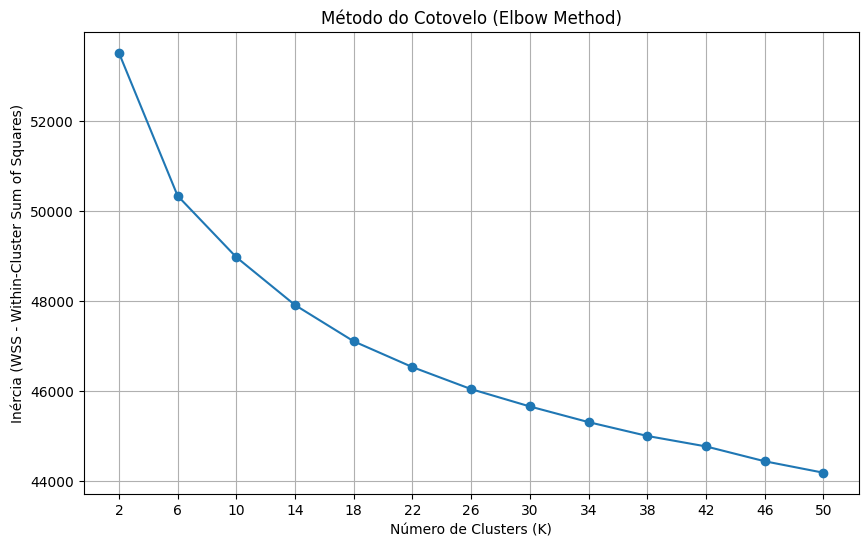


Analise o gráfico acima para identificar um 'cotovelo'.


In [126]:
if can_cluster:
    inertia = [ ]
    # Define um range de K para testar (ajuste o fim do range e o passo se necessário)
    k_range = range( 2, 51, 4 )  # Ex: De 2 a 50, de 4 em 4

    try:
        for k in k_range:
            print( f"  Testando K={k}..." )
            kmeans_elbow = KMeans(
                    n_clusters = k, random_state = 42,
                    n_init = 'auto' )  # n_init='auto' é recomendado nas versões mais recentes
            kmeans_elbow.fit( embeddings_sbert )
            inertia.append( kmeans_elbow.inertia_ )
        print( "Cálculo da inércia concluído." )

        # Plotar o gráfico do cotovelo
        plt.figure( figsize = (10, 6) )
        plt.plot( k_range, inertia, marker = 'o', linestyle = '-' )
        plt.title( 'Método do Cotovelo (Elbow Method)' )
        plt.xlabel( 'Número de Clusters (K)' )
        plt.ylabel( 'Inércia (WSS - Within-Cluster Sum of Squares)' )
        plt.xticks( k_range )
        plt.grid( True )
        plt.show()

        print( "\nAnalise o gráfico acima para identificar um 'cotovelo'." )

    except Exception as e:
        print( f"\nErro ao calcular o Método do Cotovelo: {e}" )

## 6.3 Escolhendo K: Pontuação de Silhueta (Silhouette Score)

Calcula e plota a pontuação média de silhueta para diferentes valores de K. Esta métrica avalia quão bem separados os clusters estão. Valores mais próximos de 1 indicam clusters mais densos e bem definidos. Um pico no gráfico sugere um valor de K ótimo.


--- 7.3 Calculando Pontuação de Silhueta (pode demorar) ---
  Testando K=2 para Silhueta...
    Calculando score para K=2...
    K=2, Silhouette Score=0.0761
  Testando K=5 para Silhueta...
    Calculando score para K=5...
    K=5, Silhouette Score=0.0523
  Testando K=8 para Silhueta...
    Calculando score para K=8...
    K=8, Silhouette Score=0.0451
  Testando K=11 para Silhueta...
    Calculando score para K=11...
    K=11, Silhouette Score=0.0414
  Testando K=14 para Silhueta...
    Calculando score para K=14...
    K=14, Silhouette Score=0.0413
  Testando K=17 para Silhueta...
    Calculando score para K=17...
    K=17, Silhouette Score=0.0408
  Testando K=20 para Silhueta...
    Calculando score para K=20...
    K=20, Silhouette Score=0.0395
Cálculo da pontuação de silhueta concluído.


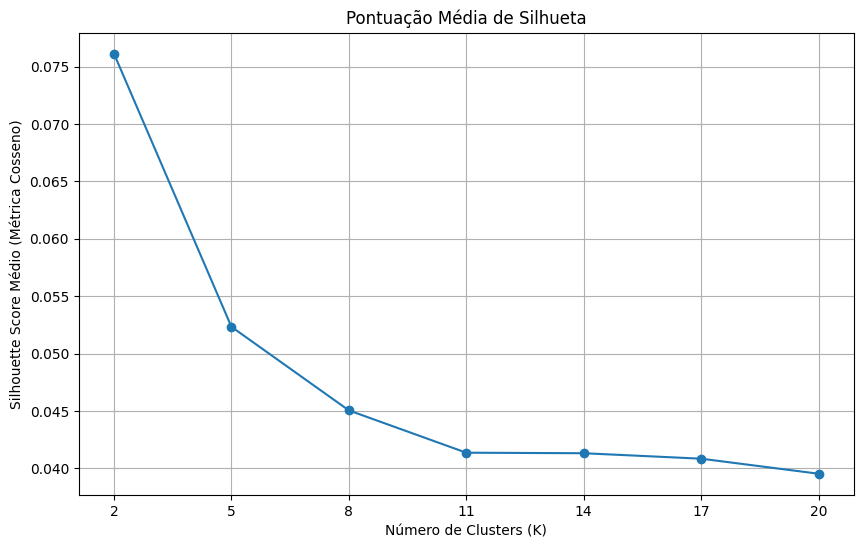


Procure por um pico (valor máximo) no gráfico de silhueta.


In [127]:
if can_cluster:
    calculate_silhouette = True

    if calculate_silhouette:
        print( "\n--- 7.3 Calculando Pontuação de Silhueta (pode demorar) ---" )
        silhouette_scores = [ ]
        # Usar um range menor para K devido ao custo
        k_range_silhouette = range( 2, 21, 3 )  # Ex: De 2 a 20, de 3 em 3

        try:
            for k in k_range_silhouette:
                print( f"  Testando K={k} para Silhueta..." )
                kmeans_silhouette = KMeans( n_clusters = k, random_state = 42, n_init = 'auto' )
                cluster_labels_temp = kmeans_silhouette.fit_predict( embeddings_sbert )
                print( f"    Calculando score para K={k}..." )
                score = silhouette_score(
                        embeddings_sbert, cluster_labels_temp, metric = 'cosine', sample_size = 2000,
                        random_state = 42 )
                silhouette_scores.append( score )
                print( f"    K={k}, Silhouette Score={score:.4f}" )
            print( "Cálculo da pontuação de silhueta concluído." )

            # Plotar o gráfico da silhueta
            plt.figure( figsize = (10, 6) )
            plt.plot( k_range_silhouette, silhouette_scores, marker = 'o', linestyle = '-' )
            plt.title( 'Pontuação Média de Silhueta' )
            plt.xlabel( 'Número de Clusters (K)' )
            plt.ylabel( 'Silhouette Score Médio (Métrica Cosseno)' )
            plt.xticks( k_range_silhouette )
            plt.grid( True )
            plt.show()

            print( "\nProcure por um pico (valor máximo) no gráfico de silhueta." )

        except Exception as e:
            print( f"\nErro ao calcular a Pontuação de Silhueta: {e}" )

## 6.4 Treinamento do Modelo K-Means Final

Com base na análise dos gráficos do Cotovelo e/ou da Silhueta, define-se o número final de clusters (K_ESCOLHIDO). Em seguida, treina-se o modelo K-Means definitivo usando todos os embeddings SBERT e o valor de K escolhido.

In [128]:
if can_cluster:
    # --- Definição de K ---
    # !!! IMPORTANTE: AJUSTE O VALOR DE K_ESCOLHIDO ABAIXO !!!
    # Analise os gráficos anteriores e defina o número de clusters desejado.
    K_ESCOLHIDO = 25  # Valor exemplo, ajuste conforme sua análise!
    print( f"\n--- 7.4 Treinando K-Means Final com K = {K_ESCOLHIDO} ---" )

    try:
        kmeans = KMeans( n_clusters = K_ESCOLHIDO, random_state = 42, n_init = 'auto' )
        # Treina o modelo com os embeddings SBERT
        kmeans.fit( embeddings_sbert )
        print( "Treinamento K-Means final concluído." )
        clusters_generated = True
    except Exception as e:
        print( f"\nErro ao treinar o K-Means final: {e}" )
        clusters_generated = False
else:
    clusters_generated = False


--- 7.4 Treinando K-Means Final com K = 25 ---
Treinamento K-Means final concluído.


## 6.5 Atribuição de Rótulos e Análise dos Clusters

Obtém os rótulos de cluster atribuídos a cada filme pelo modelo K-Means treinado. Adiciona esses rótulos como uma nova coluna ao DataFrame principal (`df`). Realiza uma análise básica, mostrando a contagem de filmes por cluster e exibindo os títulos de alguns filmes de exemplo para clusters selecionados, permitindo uma verificação qualitativa da coesão dos grupos formados.

In [129]:
if clusters_generated:
    print( "\n--- 7.5 Atribuindo Rótulos e Analisando Clusters ---" )
    # --- Obtenção e Adição dos Rótulos ---
    cluster_labels = kmeans.labels_
    df[ 'cluster_sbert' ] = cluster_labels
    print( f"Coluna 'cluster_sbert' adicionada ao DataFrame 'df'." )

    # --- Análise dos Clusters ---
    print( "\nDistribuição de filmes por cluster (contagem):" )
    # Mostra a contagem de filmes em cada cluster, ordenado pelo número do cluster
    print( df[ 'cluster_sbert' ].value_counts().sort_index() )

    print( "\nExemplos de títulos por cluster:" )
    # Define alguns clusters para inspecionar (ex: os primeiros, um do meio, o último)
    clusters_para_inspecionar = list( range( min( 3, K_ESCOLHIDO ) ) )  # Primeiros 3
    if K_ESCOLHIDO > 5: clusters_para_inspecionar.append( K_ESCOLHIDO // 2 )  # Meio
    if K_ESCOLHIDO > 1: clusters_para_inspecionar.append( K_ESCOLHIDO - 1 )  # Último
    clusters_para_inspecionar = sorted( list( set( clusters_para_inspecionar ) ) )  # Remove duplicatas e ordena

    for cluster_num in clusters_para_inspecionar:
        print( f"\n--- Cluster {cluster_num} ---" )
        # Seleciona os primeiros N títulos do cluster atual
        filmes_no_cluster = df[ df[ 'cluster_sbert' ] == cluster_num ][ 'title' ].head( 5 ).tolist()
        if filmes_no_cluster:
            for titulo_filme in filmes_no_cluster:
                print( f"  - {titulo_filme}" )
        else:
            # Isso não deve acontecer se K foi baseado nos dados, mas é uma checagem
            print( "  (Nenhum filme encontrado neste cluster)" )

    print( "\n--- Clustering e Análise Concluídos ---" )

else:
    print( "\nAnálise de clusters não pode ser realizada (clustering não executado ou falhou)." )


--- 7.5 Atribuindo Rótulos e Analisando Clusters ---
Coluna 'cluster_sbert' adicionada ao DataFrame 'df'.

Distribuição de filmes por cluster (contagem):
cluster_sbert
0     311
1     497
2     524
3     368
4     417
5     445
6     313
7     252
8     346
9     318
10    503
11    405
12    503
13    290
14    495
15    480
16    358
17    357
18    339
19    424
20    315
21    568
22    373
23    384
24    402
Name: count, dtype: int64

Exemplos de títulos por cluster:

--- Cluster 0 ---
  - Spirited Away
  - Hotarubi no Mori e
  - Howl's Moving Castle
  - Star Wars
  - The Tale of The Princess Kaguya

--- Cluster 1 ---
  - The Green Mile
  - City of God
  - Clouds
  - Woman in the Dunes
  - The Shining

--- Cluster 2 ---
  - Gabriel's Inferno: Part II
  - Dedicated to my ex
  - Five Feet Apart
  - Scenes from a Marriage
  - Eternal Sunshine of the Spotless Mind

--- Cluster 12 ---
  - The Apartment
  - Bo Burnham: Inside
  - Wild Strawberries
  - The Truman Show
  - Poverty and N

# 7. Recomendação por Cluster

In [130]:
# Verificar se a coluna de cluster e a coluna de score existem no DataFrame df
if 'cluster_sbert' not in df.columns:
    print( "Erro: Coluna 'cluster_sbert' não encontrada no DataFrame 'df'." )
    print( "Execute a célula anterior (Seção 6) para gerar os clusters." )
elif 'score' not in df.columns:
    print( "Aviso: Coluna 'score' (Weighted Rating) não encontrada no DataFrame 'df'." )
    print( "As recomendações do cluster não serão ordenadas por qualidade/popularidade." )
    # Criar score padrão para evitar erros, mas recomendações serão baseadas na ordem do DF
    df[ 'score' ] = 0.0  # Ou algum outro valor padrão, como df['vote_average']
    recommend_by_score = False
else:
    print( "Coluna 'cluster_sbert' e 'score' encontradas. Pronto para recomendar por cluster." )
    recommend_by_score = True


def recomendar_por_cluster( titulo, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes encontrando outros filmes no mesmo cluster
    do filme de entrada, ordenados por 'score' (Weighted Rating).

    Args:
        titulo (str): O título do filme base para a recomendação.
        data (pd.DataFrame): DataFrame com colunas 'title', 'cluster_sbert', 'score'.
        mapping (pd.Series): Mapeamento de títulos para índices.
        top_n (int): Número de recomendações a serem retornadas.

    Returns:
        list: Uma lista de títulos de filmes recomendados,
              ou uma mensagem de erro (str).
    """
    try:
        # Obter o índice do filme que corresponde ao título
        if titulo not in mapping:
            matches = [ t for t in mapping.index if t.lower().strip() == titulo.lower().strip() ]
            if not matches: raise KeyError
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
        else:
            idx = mapping[ titulo ]

        # Verificar se o índice é válido e se a coluna cluster existe
        if idx >= len( data ) or 'cluster_sbert' not in data.columns:
            raise ValueError( "Índice do filme inválido ou coluna de cluster ausente." )

        # Obter o número do cluster do filme de entrada
        input_movie_cluster = data.iloc[ idx ][ 'cluster_sbert' ]
        print( f"Filme '{data.iloc[ idx ][ 'title' ]}' pertence ao Cluster: {input_movie_cluster}" )

        # Filtrar o DataFrame para obter outros filmes do mesmo cluster
        # Exclui o próprio filme de entrada usando o índice
        cluster_movies = data[ (data[ 'cluster_sbert' ] == input_movie_cluster) & (data.index != idx) ]

        if cluster_movies.empty:
            return f"Nenhum outro filme encontrado no Cluster {input_movie_cluster} para recomendar."

        # Ordenar os filmes do cluster pelo 'score' (Weighted Rating) em ordem decrescente
        if recommend_by_score and 'score' in cluster_movies.columns:
            cluster_movies_sorted = cluster_movies.sort_values( 'score', ascending = False )
        else:
            # Se não for ordenar por score, apenas pega os primeiros que aparecerem
            cluster_movies_sorted = cluster_movies

        # Selecionar os top_n títulos
        recommendations = cluster_movies_sorted[ 'title' ].head( top_n ).tolist()

        return recommendations

    except KeyError:
        # Mensagem de erro mais informativa (reutilizada da função anterior)
        suggestion = [ t for t in mapping.index if titulo.lower() in t.lower() ][ :5 ]
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion: error_msg += f" Você quis dizer algum destes? {suggestion}"
        return error_msg
    except ValueError as ve:
        print( f"Erro ao processar filme/cluster: {ve}" )
        return "Não foi possível gerar recomendações devido a um erro interno."
    except Exception as e:
        return f"Ocorreu um erro inesperado durante a recomendação por cluster: {e}"

Aviso: Coluna 'score' (Weighted Rating) não encontrada no DataFrame 'df'.
As recomendações do cluster não serão ordenadas por qualidade/popularidade.


## 7.1 Aplicação

In [131]:
if 'cluster_sbert' in df.columns:  # Só executa se os clusters foram gerados
    filme_exemplo_cluster = "The Dark Knight Rises"  # Use o mesmo filme ou outro

    print( f"\n--- Recomendações por Cluster para '{filme_exemplo_cluster}' ---" )
    recomendacoes_cluster = recomendar_por_cluster( filme_exemplo_cluster, top_n = 10 )  # Pega top 10 do cluster

    if isinstance( recomendacoes_cluster, list ):
        if not recomendacoes_cluster:
            print( "Nenhuma recomendação encontrada." )
        else:
            for i, filme in enumerate( recomendacoes_cluster ):
                # Opcional: buscar e mostrar o score do filme recomendado
                # score_rec = df.loc[df['title'] == filme, 'score'].iloc[0]
                # print(f"{i + 1}. {filme} (Score: {score_rec:.2f})")
                print( f"{i + 1}. {filme}" )
    else:
        # Imprime a mensagem de erro retornada pela função
        print( recomendacoes_cluster )

    # Exemplo 2
    filme_exemplo_cluster_2 = "Avatar"
    print( f"\n--- Recomendações por Cluster para '{filme_exemplo_cluster_2}' ---" )
    recomendacoes_cluster_2 = recomendar_por_cluster( filme_exemplo_cluster_2, top_n = 10 )

    if isinstance( recomendacoes_cluster_2, list ):
        if not recomendacoes_cluster_2:
            print( "Nenhuma recomendação encontrada." )
        else:
            for i, filme in enumerate( recomendacoes_cluster_2 ):
                print( f"{i + 1}. {filme}" )
    else:
        print( recomendacoes_cluster_2 )
else:
    print( "\nNão é possível gerar recomendações por cluster pois a coluna 'cluster_sbert' não foi criada." )


--- Recomendações por Cluster para 'The Dark Knight Rises' ---
Filme 'The Dark Knight Rises' pertence ao Cluster: 23
1. 12 Angry Men
2. Rear Window
3. Se7en
4. The Silence of the Lambs
5. Witness for the Prosecution
6. Investigation of a Citizen Above Suspicion
7. Vertigo
8. The Usual Suspects
9. Memento
10. Double Indemnity

--- Recomendações por Cluster para 'Avatar' ---
Filme 'Avatar' pertence ao Cluster: 10
1. Evangelion: 3.0+1.0 Thrice Upon a Time
2. Spider-Man: Into the Spider-Verse
3. Neon Genesis Evangelion: The End of Evangelion
4. Interstellar
5. Justice League Dark: Apokolips War
6. Back to the Future
7. Avengers: Endgame
8. Steven Universe: The Movie
9. Avengers: Infinity War
10. Miraculous World: New York, United HeroeZ
